<a href="https://colab.research.google.com/github/Filquichante/Machina/blob/main/Trial_with_Hugginface_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Charger le dataset complet
dataset = load_dataset("tpremoli/CelebA-attrs")

# Diviser le dataset en ensembles de formation et de test
train_test_split = dataset['train'].train_test_split(test_size=0.2)

# Extraire les ensembles de formation et de test
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/162770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/19962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19867 [00:00<?, ? examples/s]

In [ ]:
### Variables de normalisation
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

#Variables globales
BATCH_SIZE = 128
LEARNING_RATE = 0.1
EPOCHS = 3

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
jitter = transforms.Compose(
    [transforms.ColorJitter(brightness=0.5, hue=0.5),
     ToTensor(),
     transforms.Normalize(mean=mean, std=std)
     ]
)

In [ ]:
def transformation(data_images):
    data_images["pixel_values"] = [jitter(image.convert("RGB")) for image in data_images]
    return data_images

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        super().__init__()
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Charger l'image
        image = self.dataset[idx]["image"]

        # Appliquer les transformations (si disponibles)
        if self.transform:
            image = self.transform(image)

        # Charger les étiquettes
        attributes = [
    '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
    'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses',
    'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes',
    'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling',
    'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
    'Wearing_Necktie', 'Young'
]
        labels = torch.tensor([self.dataset[idx][attribute] for attribute in attributes], dtype=torch.float32)

        return torch.Tensor(np.array(image))/256, labels

In [ ]:
train_celeba_dataset = CelebADataset(train_dataset)
test_celeba_dataset = CelebADataset(test_dataset)

# Créer un DataLoader pour faciliter l'itération sur le dataset
train_dataloader = DataLoader(train_celeba_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_celeba_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def denormalize(tensor, mean=mean, std=std):
    mean = torch.tensor(mean)
    std = torch.tensor(std)
    print(std.shape, mean.shape)
    return tensor * std + mean

torch.Size([218, 178, 3])


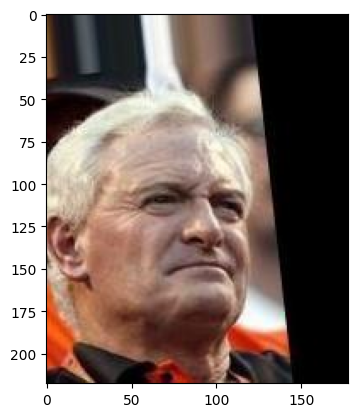

In [ ]:
for image, caracs in train_dataloader:
  plt.subplots(1)
  plt.imshow(image[0])
  print(image[0].shape)
  break


### Okay maintenant que je connais vraiment bien mon dataset, on peut commencer l'entrainement

In [ ]:
class CNN_Model_V0(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, padding = 1)

    self.pool = nn.MaxPool2d(kernel_size = 2)

    self.linear1 = nn.Linear(in_features = 19360, out_features = 40)

  def forward(self, image):
    x = image
    x = x.permute(0,3,1,2)
    x = torch.nn.functional.interpolate(x, (178,178))
    print(x.shape)
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = torch.flatten(x, start_dim=1)
    print(x.shape)
    x = self.linear1(x)
    return x

In [ ]:
Model0 = CNN_Model_V0().to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr=LEARNING_RATE, params=Model0.parameters())

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    n = 0
    for batch, (X, y) in enumerate(dataloader):
        n+=1
        if n >= 10:
            break
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    n = 0
    with torch.no_grad():
        for X, y in dataloader:
            n+=1
            if n>=10:
                break
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, Model0, loss_fn, optimizer)
    test(test_dataloader, Model0, loss_fn)
print("Done!")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
-------------------------------
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss: 0.761340  [  128/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss: -1.554455  [  256/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss: -34.382118  [  384/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss: -3125.903809  [  512/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss: -14419778.000000  [  640/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss: -248706389508096.000000  [  768/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss: -75273964497697166088179023872.000000  [  896/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])
loss:     nan  [ 1024/130216]
torch.Size([128, 3, 178, 178])
torch.Size([128, 19360])


  0%|          | 0/10 [00:56<?, ?it/s]


KeyboardInterrupt: 